In [1]:
import sys
import os
import subprocess

from six import string_types


import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy
from skimage import io
from scipy import ndimage
from IPython.display import display
%matplotlib inline

In [2]:
from os import listdir

In [3]:
listdir('../input/planets-dataset/planet/planet/train-jpg')[:10]

['train_30370.jpg',
 'train_11814.jpg',
 'train_14358.jpg',
 'train_18588.jpg',
 'train_36435.jpg',
 'train_20663.jpg',
 'train_27590.jpg',
 'train_34219.jpg',
 'train_35721.jpg',
 'train_32767.jpg']

In [4]:
len(listdir('../input/planets-dataset/planet/planet/train-jpg'))

40479

# **Label Preparation**

In [5]:
labels_df = pd.read_csv("../input/planets-dataset/planet/planet/train_classes.csv")
labels_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [6]:
# Build list with unique labels
label_list = []
for tag_str in labels_df.tags.values:
    labels = tag_str.split(' ')
    for label in labels:
        if label not in label_list:
            label_list.append(label)

In [7]:
# Add onehot features for every label
for label in label_list:
    labels_df[label] = labels_df['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)
# Display head
labels_df.head()

,image_name,tags,haze,primary,agriculture,clear,water,habitation,road,cultivation,slash_burn,cloudy,partly_cloudy,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
0,train_0,haze primary,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,train_1,agriculture clear primary water,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,train_2,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,train_3,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,train_4,agriculture clear habitation primary road,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0


In [8]:
labels_df['image_name'] = labels_df['image_name'].apply(lambda x: '{}.jpg'.format(x)) 

In [9]:
y_col = list(labels_df.columns[2:])
y_col

['haze',
 'primary',
 'agriculture',
 'clear',
 'water',
 'habitation',
 'road',
 'cultivation',
 'slash_burn',
 'cloudy',
 'partly_cloudy',
 'conventional_mine',
 'bare_ground',
 'artisinal_mine',
 'blooming',
 'selective_logging',
 'blow_down']

In [10]:
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(labels_df, 
                                   test_size = 0.25, 
                                   random_state = 2018)
print('train', train_df.shape[0], 'validation', valid_df.shape[0])

train 30359 validation 10120


In [11]:
train_df.head(3)

,image_name,tags,haze,primary,agriculture,clear,water,habitation,road,cultivation,slash_burn,cloudy,partly_cloudy,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
17413,train_17413.jpg,partly_cloudy primary,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
29830,train_29830.jpg,partly_cloudy primary,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
39836,train_39836.jpg,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [12]:
valid_df.head(3)

,image_name,tags,haze,primary,agriculture,clear,water,habitation,road,cultivation,slash_burn,cloudy,partly_cloudy,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
18991,train_18991.jpg,clear primary water,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
31884,train_31884.jpg,haze primary,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2325,train_2325.jpg,agriculture clear cultivation habitation prima...,0,1,1,1,1,1,0,1,0,0,0,0,0,0,0,0,0


In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
IMG_SIZE = (128, 128)
datagen = ImageDataGenerator(
                                
                            rescale=1/255,
                              rotation_range=5,
                              shear_range=0.1,
                              zoom_range=0.1,
                              width_shift_range=0.1,
                              height_shift_range=0.1,
                              horizontal_flip=True,
                              fill_mode='nearest')


train_gen = datagen.flow_from_dataframe(dataframe= train_df,
        directory='../input/planets-dataset/planet/planet/train-jpg/', 
                                        x_col='image_name', 
                                        y_col=y_col,
       target_size=IMG_SIZE, 
                                        class_mode='raw',
                                        batch_size= 32)
valid_datagen = ImageDataGenerator(rescale=1/255)

valid_gen = valid_datagen.flow_from_dataframe(dataframe= valid_df,
        directory='../input/planets-dataset/planet/planet/train-jpg/', 
                                        x_col='image_name', 
                                        y_col=y_col,
       target_size=IMG_SIZE,
                                        class_mode='raw',
                                         batch_size= 128)






Found 30359 validated image filenames.
Found 10120 validated image filenames.


In [14]:
import tensorflow as tf
from tensorflow.keras.layers import MaxPool2D, Conv2D, Dropout, BatchNormalization
resNet50V2_model=tf.keras.applications.ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(128,128,3),
    pooling=None,
    classes=17,
    classifier_activation="softmax",
)
resNet50V2_model.trainable = True

2022-03-22 22:14:42.436051: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-22 22:14:42.529916: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-22 22:14:42.530613: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-22 22:14:42.531915: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

94683136/94668760 [==============================] - 1s 0us/step


In [15]:
resNet50V2_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 66, 66, 64)   0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [16]:
from keras import Sequential
from keras.layers import Dense,Flatten


model = Sequential()
model.add(Conv2D(512, kernel_size=(1,1), activation='relu'))
model.add(MaxPool2D((2,2), strides=2, padding='same'))
model.add(Dropout(0.8))
    
model.add(Conv2D(512, kernel_size=(1,1), activation='relu'))
model.add(MaxPool2D((2,2), strides=2, padding='same'))
model.add(Dropout(0.8))
    
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.8))
  
model.add(Flatten())
model.add(Dense(17, activation='softmax'))


learning_rate = 0.000001
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
model.compile(optimizer = optimizer, 
              loss = tf.keras.losses.CategoricalCrossentropy(), 
              metrics = ['accuracy'])
STEP_SIZE_TRAIN = train_gen.n // train_gen.batch_size
STEP_SIZE_VALID = valid_gen.n // valid_gen.batch_size

In [17]:
history = model.fit(train_gen,
          steps_per_epoch = STEP_SIZE_TRAIN,
          validation_data = valid_gen ,
          validation_steps = STEP_SIZE_VALID,
          epochs = 1)

2022-03-22 22:14:49.265540: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
2022-03-22 22:14:49.358810: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


948/948 [==============================] - 339s 351ms/step - loss: 8.3922 - accuracy: 0.6372 - val_loss: 6.1623 - val_accuracy: 0.8577


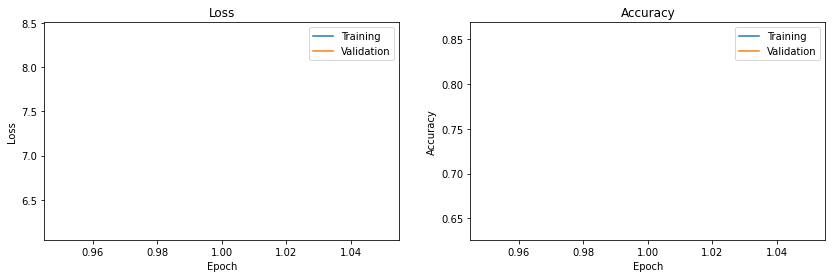

In [18]:
history = history.history
n_epochs = len(history['loss'])

plt.figure(figsize=[14,4])
plt.subplot(1,2,1)
plt.plot(range(1, n_epochs+1), history['loss'], label='Training')
plt.plot(range(1, n_epochs+1), history['val_loss'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(range(1, n_epochs+1), history['accuracy'], label='Training')
plt.plot(range(1, n_epochs+1), history['val_accuracy'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
plt.legend()
plt.show()